# Importing Libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from math import ceil

# Reading data

In [3]:
files_list = os.listdir('../data')
target_file_name = 'profile.txt'
sensors_list = [file.split('.txt')[0] for file in files_list if file != target_file_name]

In [4]:
target = pd.read_csv(f'../data/{target_file_name}', delimiter='\t', header=None)[3] # 3 is reference to the Hydraulic accumulator

In [5]:
experiment_time_seconds = 60
sensors_data_dict_freq = {}
sensors_names_dict_freq = {}
for sensor in sensors_list:
    df_sensor = pd.read_csv(f'../data/{sensor}.txt', delimiter='\t', header=None)
    n_samples = df_sensor.shape[1]
    freq = n_samples/experiment_time_seconds
    if freq not in sensors_data_dict_freq:
        sensors_data_dict_freq[freq]=df_sensor
        sensors_names_dict_freq[freq]=[sensor]
    else:
        sensors_data_dict_freq[freq]=np.dstack((sensors_data_dict_freq[freq], df_sensor))
        sensors_names_dict_freq[freq]+=[sensor]


In [6]:
for freq, names_list in sensors_names_dict_freq.items():
    n_sensors = len(names_list)
    print(f'There are {n_sensors} sensors with the frequency of {int(freq)} Hz.')

There are 8 sensors with the frequency of 1 Hz.
There are 7 sensors with the frequency of 100 Hz.
There are 2 sensors with the frequency of 10 Hz.


In [7]:
one_hz_data = sensors_data_dict_freq[1]
one_hz_names = sensors_names_dict_freq[1]

ten_hz_data = sensors_data_dict_freq[10]
ten_hz_names = sensors_names_dict_freq[10]

hund_hz_data = sensors_data_dict_freq[100]
hund_hz_names = sensors_names_dict_freq[100]

In [8]:
for freq, data in sensors_data_dict_freq.items():
    print(f'{int(freq)} Hz sensors data shape: {data.shape}')

1 Hz sensors data shape: (2205, 60, 8)
100 Hz sensors data shape: (2205, 6000, 7)
10 Hz sensors data shape: (2205, 600, 2)


# Exploratory Data Analysis

According to the documentation the representation of the target values is:

- Hydraulic accumulator / bar: \
      - 130: optimal pressure (599 instances) \
      - 115: slightly reduced pressure (399 instances) \
      - 100: severely reduced pressure (399 instances) \
      - 90: close to total failure (808 instances)

For easier interpretability I will assume:

- Hydraulic accumulator / bar: \
      - 0: optimal pressure (599 instances) \
      - 1: slightly reduced pressure (399 instances) \
      - 2: severely reduced pressure (399 instances) \
      - 3: close to total failure (808 instances)

In [9]:
rename_target = {
    130:0,
    115:1,
    100:2,
    90:3
}
target = target.apply(lambda x:rename_target[x])

In [10]:
df_count = pd.DataFrame({'condition':target.value_counts().index, 'count':target.value_counts().values})
df_count = df_count.sort_values(by='condition').reset_index(drop=True)
df_count

,condition,count
0,0,599
1,1,399
2,2,399
3,3,808


Checking any missing value

In [11]:
def check_missing_values(data:np.ndarray, names:list) -> None:    
    nan_values_sensors = sum(np.isnan(data))
    n_samples_sensor = data.shape[0]*data.shape[1]
    for sensor_idx in range(nan_values_sensors.shape[1]):
        nan_values_sensor = sum(nan_values_sensors[:,sensor_idx])
        nan_values_perc = round(100*nan_values_sensor/n_samples_sensor,2)
        print(f'The sensor {names[sensor_idx]} has {nan_values_perc} % of missing values.')

In [12]:
check_missing_values(one_hz_data, one_hz_names)
check_missing_values(ten_hz_data, ten_hz_names)
check_missing_values(hund_hz_data, hund_hz_names)

The sensor CE has 0.0 % of missing values.
The sensor CP has 0.0 % of missing values.
The sensor SE has 0.0 % of missing values.
The sensor TS1 has 0.0 % of missing values.
The sensor TS2 has 0.0 % of missing values.
The sensor TS3 has 0.0 % of missing values.
The sensor TS4 has 0.0 % of missing values.
The sensor VS1 has 0.0 % of missing values.
The sensor FS1 has 0.0 % of missing values.
The sensor FS2 has 0.0 % of missing values.


The sensor EPS1 has 0.0 % of missing values.
The sensor PS1 has 0.0 % of missing values.
The sensor PS2 has 0.0 % of missing values.
The sensor PS3 has 0.0 % of missing values.
The sensor PS4 has 0.0 % of missing values.
The sensor PS5 has 0.0 % of missing values.
The sensor PS6 has 0.0 % of missing values.


Data visualization

In [13]:
target_color_dict = {
    0:'green',
    1:'gold',
    2:'orange',
    3:'red'
}

In [14]:
def plot_experiment_behavior(data, names, experiment_idx):
    n_cols = 2
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    condition = target[experiment_idx]
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        ax.plot(data[experiment_idx,:,sensor_idx], label=condition, color=target_color_dict[condition])
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz sensors behavior', fontsize=18)
    plt.tight_layout()
    plt.show()

In [15]:
def random_experiment_by_condition(target:pd.Series, condition:int) -> int:
    target_by_condition = target[target==condition].index
    return np.random.choice(target_by_condition)

In [16]:
random_experiment_idx = np.random.choice(target.index)
random_experiment_idx = random_experiment_by_condition(target, 0)

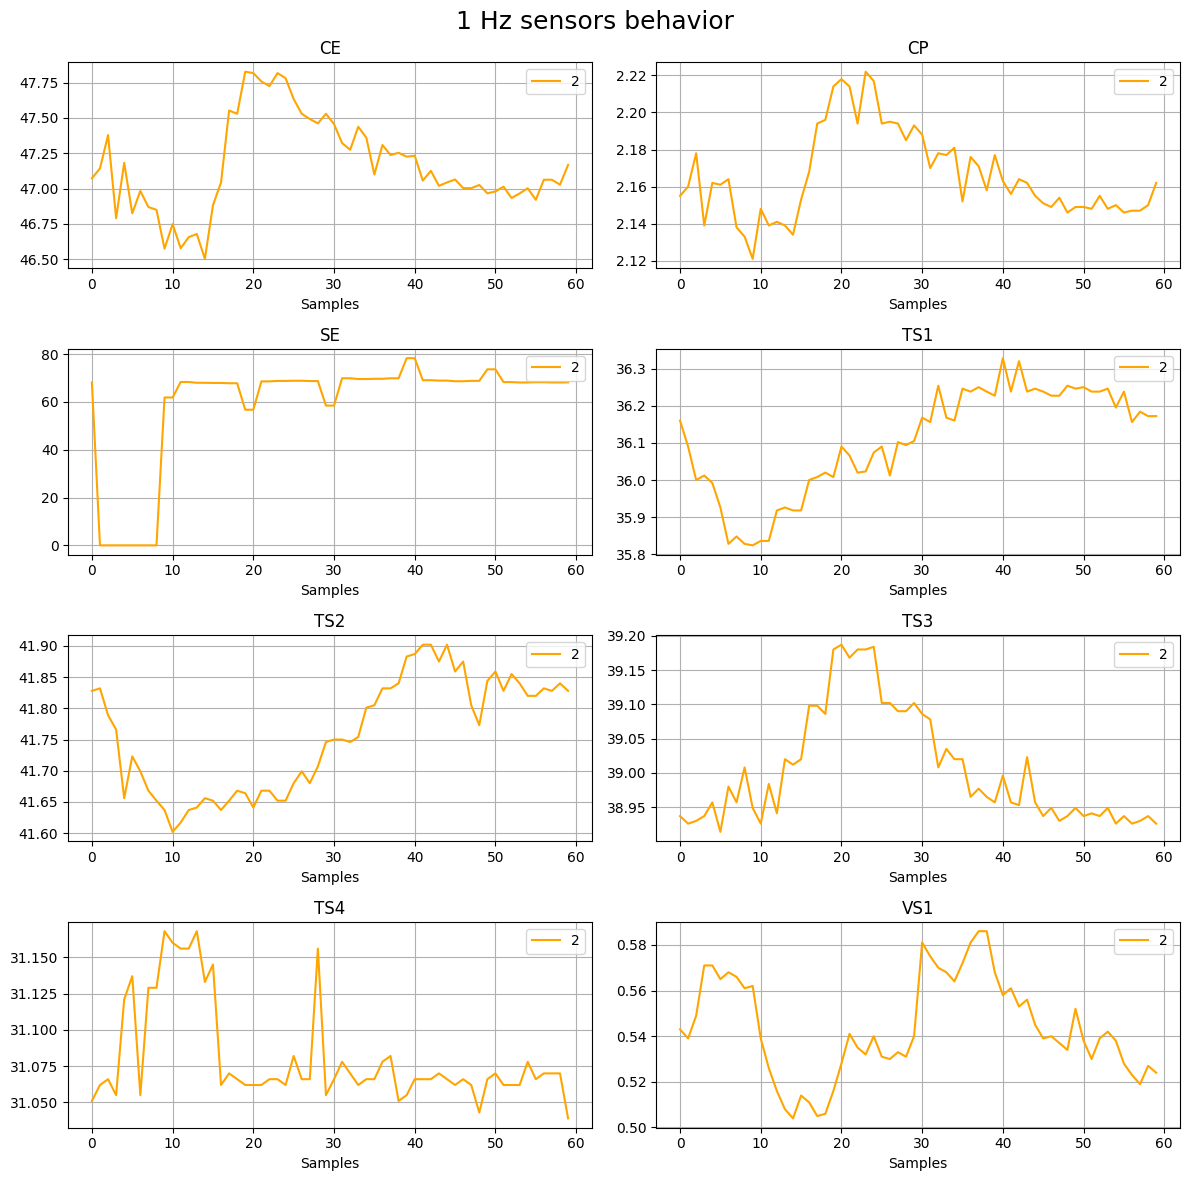

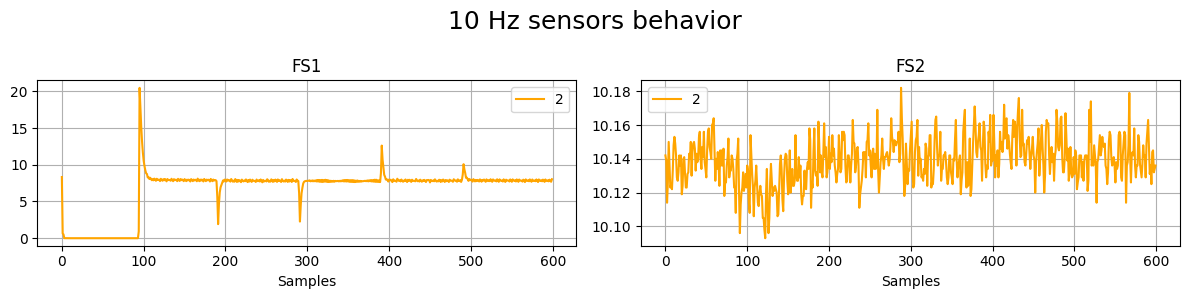

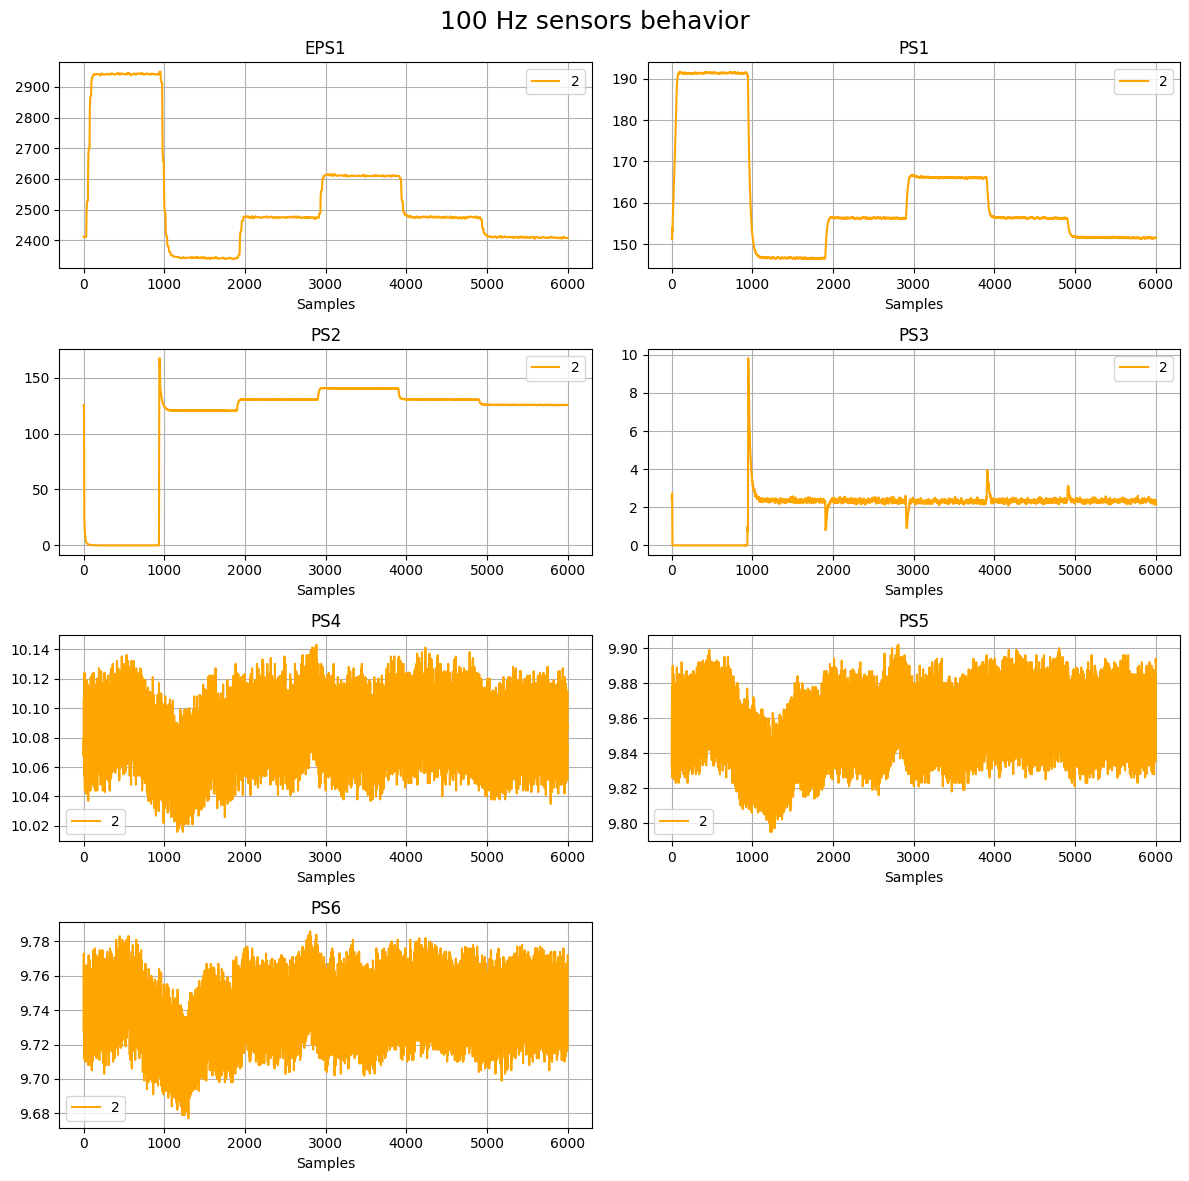

In [17]:
random_experiment_idx = np.random.choice(target.index)
plot_experiment_behavior(one_hz_data, one_hz_names, random_experiment_idx)
plot_experiment_behavior(ten_hz_data, ten_hz_names, random_experiment_idx)
plot_experiment_behavior(hund_hz_data, hund_hz_names, random_experiment_idx)

Check if any sensor has constant value for many experiments.

In [18]:
def calculate_percentage_constant_values(data, names, std_multiplier=1):
    idx_exp_constant_values_sensors = []
    for sensor_idx in range(data.shape[2]):
        n_experiments = data.shape[0]
        samples = data.shape[1]
        sensor_data = data[:,:,sensor_idx]
        # Calculate mean and standard deviation for each experiment
        mean_values = np.mean(sensor_data, axis=1)
        std_values = np.std(sensor_data, axis=1)

        count = 0
        idx_exp_constant_values=[]
        for exp in range(n_experiments):
            
            # Define upper and lower limits for constant values
            upper_limit = mean_values[exp] + std_multiplier * std_values[exp]
            lower_limit = mean_values[exp] - std_multiplier * std_values[exp]
            # Calculate percentage of constant values for the current experiment
            perc_constant_values = 100 * np.sum((sensor_data[exp] >= lower_limit) & (sensor_data[exp] <= upper_limit)) / samples
            # Check if all values in the current experiment are constant
            if perc_constant_values == 100:
                count += 1
                idx_exp_constant_values.append(exp)
        idx_exp_constant_values_sensors.append(idx_exp_constant_values)
                
        # Calculate the percentage of experiments without oscillation for the current sensor
        percentage = round(100*count / n_experiments, 2)
        print(f'The sensor {names[sensor_idx]} has {percentage} % of experiments without oscillation')
    
    return idx_exp_constant_values_sensors

In [19]:
_ = calculate_percentage_constant_values(one_hz_data, one_hz_names)
_ = calculate_percentage_constant_values(ten_hz_data, ten_hz_names)
_ = calculate_percentage_constant_values(hund_hz_data, hund_hz_names)

The sensor CE has 0.0 % of experiments without oscillation
The sensor CP has 0.0 % of experiments without oscillation
The sensor SE has 0.0 % of experiments without oscillation
The sensor TS1 has 0.0 % of experiments without oscillation
The sensor TS2 has 0.0 % of experiments without oscillation
The sensor TS3 has 0.0 % of experiments without oscillation
The sensor TS4 has 0.0 % of experiments without oscillation
The sensor VS1 has 0.0 % of experiments without oscillation
The sensor FS1 has 0.0 % of experiments without oscillation
The sensor FS2 has 0.0 % of experiments without oscillation
The sensor EPS1 has 0.0 % of experiments without oscillation
The sensor PS1 has 0.0 % of experiments without oscillation
The sensor PS2 has 0.0 % of experiments without oscillation
The sensor PS3 has 0.0 % of experiments without oscillation
The sensor PS4 has 56.15 % of experiments without oscillation
The sensor PS5 has 0.0 % of experiments without oscillation
The sensor PS6 has 0.0 % of experiments 

As we can see, the sensor PS4 has no oscilation in most of the experiments. Lets se if we can remove this sensor from the analysis.

In [20]:
def plot_multiple_conditions_behavior(data, names, target):
    n_cols = 2
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    conditions = target.unique()
    
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        for condition in conditions:
            experiment_idx = np.random.choice(target[target==condition].index)
            ax.plot(data[experiment_idx,:,sensor_idx], label=condition, color=target_color_dict[condition])
        
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz sensors behavior', fontsize=18)
    plt.tight_layout()
    plt.show()

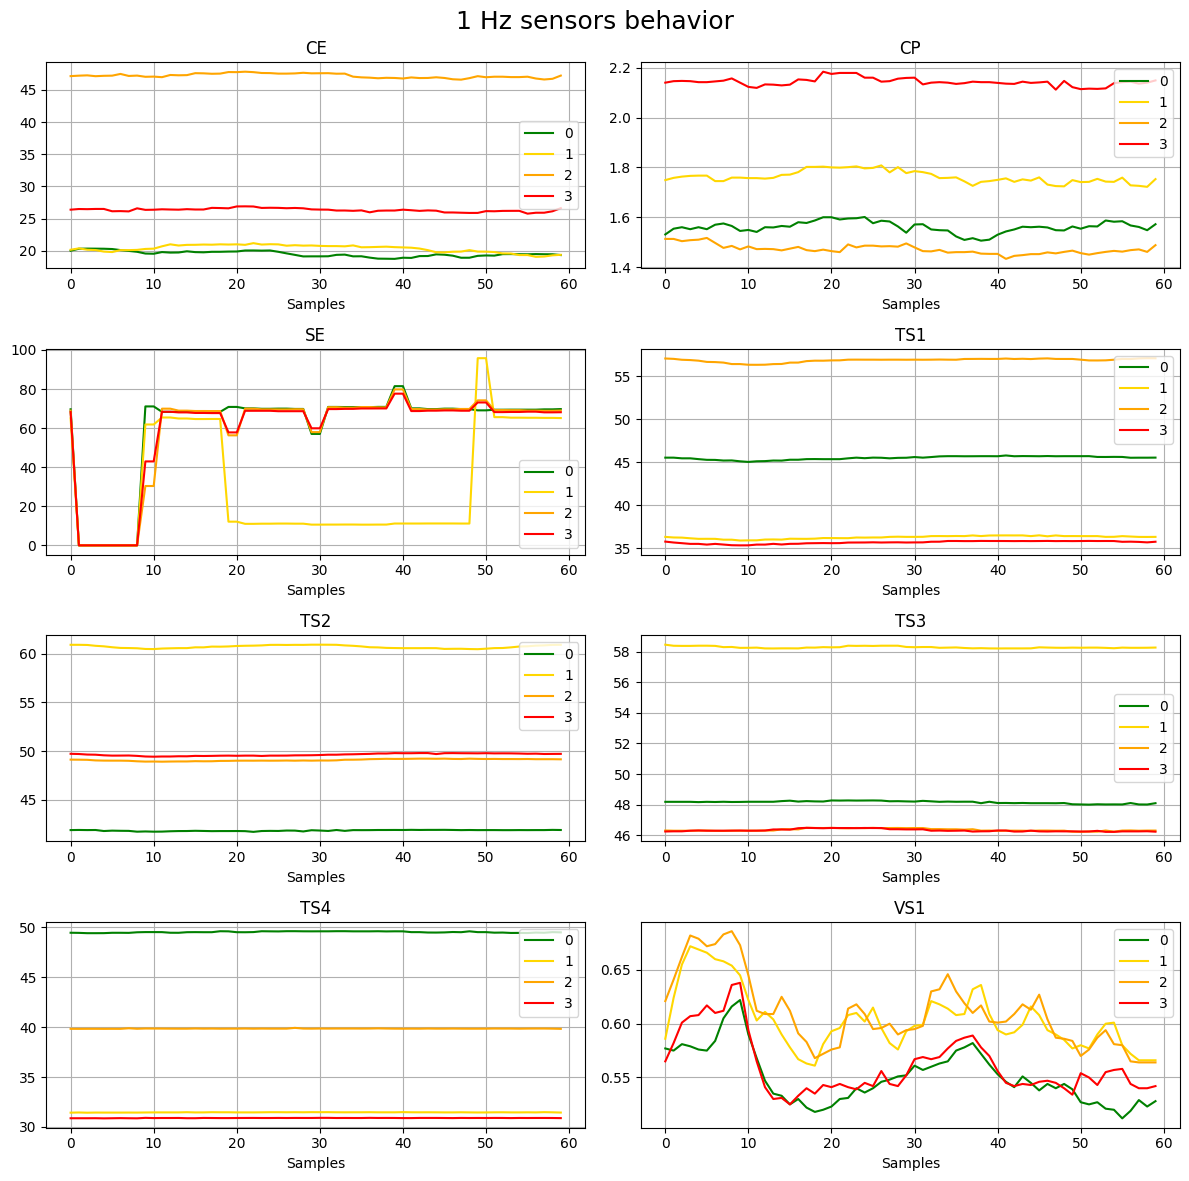

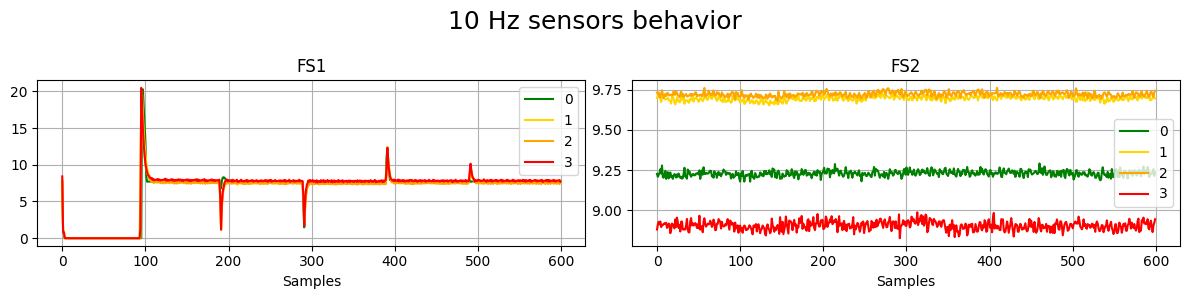

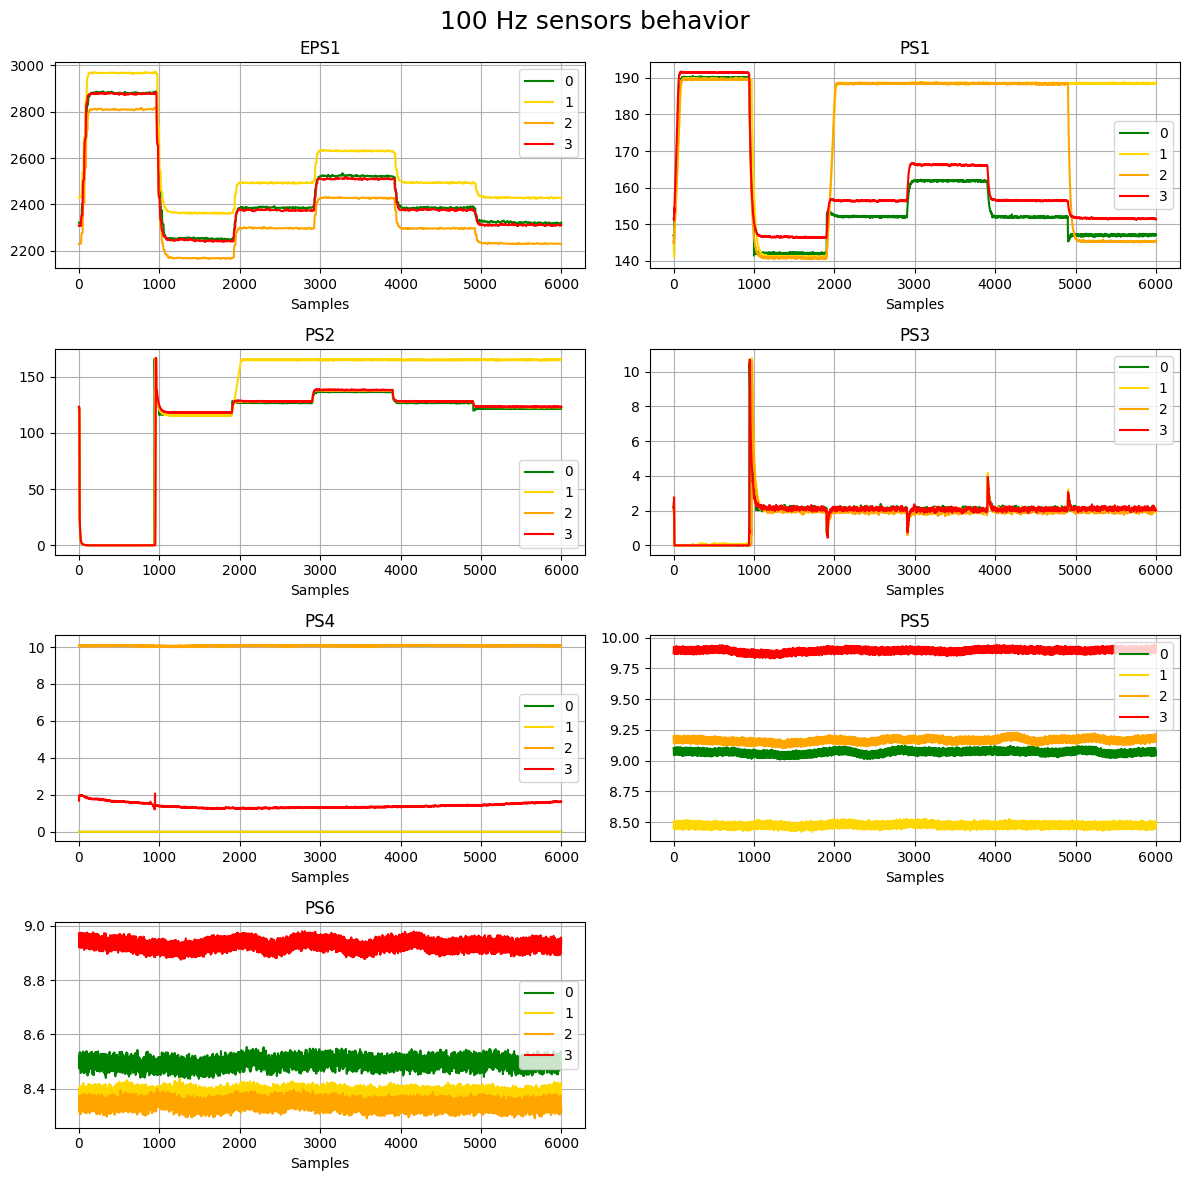

In [21]:
plot_multiple_conditions_behavior(one_hz_data, one_hz_names, target)
plot_multiple_conditions_behavior(ten_hz_data, ten_hz_names, target)
plot_multiple_conditions_behavior(hund_hz_data, hund_hz_names, target)

In [63]:
import plotly.graph_objects as go

data = one_hz_data
names = one_hz_names
sensor = 2
fig = go.Figure()
mean = np.mean(data[:,:,sensor],axis=0)
std = np.std(data[:,:,sensor],axis=0)

fig.add_trace(go.Scatter(
    y= mean,
    name='mean',
    line=dict(width=4)))

fig.add_trace(go.Scatter(
    y= mean+std,
    name='mean + std',
    fill='tonexty',
    line=dict(color='gray',
              dash='dash')))

fig.add_trace(go.Scatter(
    y= mean-std,
    name='mean - std',
    fill='tonexty',
    line=dict(color='gray',
              dash='dash')))


fig.update_layout(title=f'{names[sensor]}',
                  xaxis_title='Samples',
                  yaxis_title='Value')
